In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap
import os

In [2]:
# choose basa or GG
database = 'basa' # 'basa' or 'GG'

if database == 'basa':
    results = 'results_basa'
    data_species = 'GAM_species/species_fit_140_0.01.pkl'
    windows = [(0, 40), (20, 60), (40, 80), (60, 100), (80, 120), (100, 140)]
    windows = [(0, 50), (51, 84), (85, 140)]

if database == 'GG':
    results = 'results_GG'
    data_species = '../data_GG/GAM/species_fit_301_0.01.pkl'
    windows = [(0, 100), (50, 150), (100, 200), (150, 250), (200, 300)]
    windows = [(150, 199), (200, 249)]
    windows = [(0, 56), (57, 149), (150, 249), (250, 300)]



species_index = pd.read_pickle(f'{results}/species_index.pkl')
species_index_T = pd.Series(species_index)
species_index_T = pd.Series(species_index_T.index, index = species_index_T.values)
species_index_T = species_index_T.to_dict()

if database == 'basa':
    species_index_non_aq = {k: v for k, v in species_index.items()}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}
    non_aq_species = list(species_index_non_aq.keys())
if database == 'GG':
    # ONLY NON AQUATIC SPECIES
    non_aq_species = 'Alchemilla,Chenopodiaceae,Artemisia,Cichoroideae,Asteroideae,Carduus,Asteraceae,Vernonia,Polygonum,Tribulus,Galium,Brassicaceae,Caryophylaceae,Swertia,Senecio,Erica,Hypericum,Anthospermum,Cerastium,Apiaceae,Podocarpus,Euclea,Hagenia,Juniperus,Myrsine,Rapanea,Rosa,Schefflera,Brucea,Sapotaceae,Iridaceae,Anthyllis,Maytenus,Buxus,Psydrax,Celastraceae,Celtis,Dodonaea,Ekebergia,Ephedra,Clematis,Myrica,Hypoestes,Ziziphus,Acanthus,Allophylus,Acacia,Combretum,Commiphora,Cussonia,Dobera,Lannea,Macaranga,Olea,Jasminum,Rhus,Securinega,Teclea,Zanthoxylum,Cassia,Capparidaceae,Acalypha,Euphorbia,Euphorbiacea,Phyllantus,Tamarindus,Alchornea,Aloe,Asphodellus,Leguminosae,Rubiaceae,Blepharis,Justicia,Heliotropium,Kohautia,Indigofera,Lamiaceae,Cerealia,Plantago,Planceolata,Poaceae,Rumex,Solanum,Urticaceae,Ricinus,Saussurea'.replace(' ','_').split(',')

    # species_index_non_aq = species_index
    # species_index_T_non_aq = species_index_T
    species_index_non_aq = {k: v for k, v in species_index.items() if k in set(non_aq_species)}
    species_index_T_non_aq = {v: k for k, v in species_index_non_aq.items()}


abundances = pd.read_pickle(data_species)
for species in abundances.columns:                  # 0.001 if percentages, 0.01 if PAR without lycopodium
    abundances[species]['y'][abundances[species]['y'] < 0.001] = 0

(0.0, 30.0)

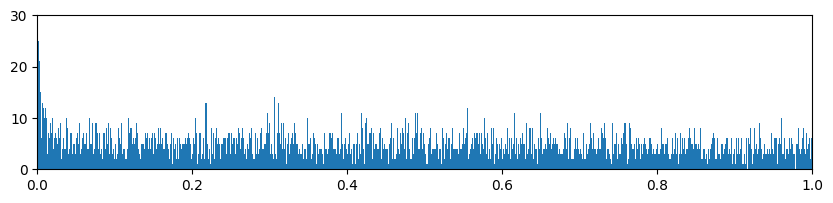

In [3]:
n = 20

# load the p-values
p_values = pd.read_pickle('results_basa/sensitivity_CGC/abundances_1/original_table_p_values_0-50.pkl')
p_values[p_values == 1.0] = np.nan

fig,ax = plt.subplots(figsize=(10, 2))
ax.hist(p_values.flatten(), bins=1000, range=(0, 1));
ax.set_xlim(0, 1)
ax.set_ylim(0, 30)

In [ ]:
import networkx as nx

# grab the top L edges
# L = 100

def get_graphs(causality_name = 'sensitivity_CGC/abundances_1'):
    graphs = []
    granger_causalities = []
    granger_causalities_p_values = []
    for idx,(start,end) in enumerate(windows):

        granger_causality = pd.read_pickle(f'{results}/{causality_name}/original_table_{start}-{end}.pkl')
        granger_causality[granger_causality > 100] = 0
        granger_causality[granger_causality < -100] = 0
        # granger_causality[np.eye(granger_causality.shape[0], dtype=bool)] = np.nan
        granger_causalities.append(granger_causality)

        granger_causality_p_values = pd.read_pickle(f'{results}/{causality_name}/original_table_p_values_{start}-{end}.pkl')
        granger_causality_p_values[np.eye(granger_causality_p_values.shape[0], dtype=bool)] = np.nan
        granger_causalities_p_values.append(granger_causality_p_values)

        # for the TE p_values (p_values_list) or the gc p_values (granger_causalities_p_values)
        # adjacency = p_values_list[idx]
        adjacency = granger_causalities_p_values[idx]
        # remove na from the numpy array adjacency
        adjacency = np.nan_to_num(adjacency, nan=1.0)
        # ONLY NON AQUATIC SPECIES
        species_list = list(species_index_T_non_aq.keys())

        # adjacency_non_aq = adjacency[np.ix_(species_list, species_list)]
        # cut_value = np.sort(adjacency_non_aq.flatten())[L]

        cut_value = 0.01

        adjacency_pvalued = (adjacency <= cut_value).astype(int)
        adjacency = granger_causalities[idx] * adjacency_pvalued
        
        graph = nx.from_numpy_array(adjacency, create_using=nx.DiGraph, edge_attr='weight')
        # remove all nodes that are not in the non_aq_species list
        graph.remove_nodes_from([node for node in graph.nodes() if species_index_T[node] not in non_aq_species])
        graphs.append(graph)
        print(cut_value, graph.number_of_edges())
        
    return graphs, granger_causalities, granger_causalities_p_values

    # explanation cause it's confusing
    # we need to create the graph with the indices of the original species index, so we use the whole adjacency matrix
    # however to remove the aquatic nodes and keep 100 links, we count them on the adjacency_non_aq, then create the whole graph, then remove again the aquatic nodes
    # this should leave about the 100 links

In [50]:
windows=[(0,50)]
causality_name = 'sensitivity_CGC/abundances_3' # 'granger_causalities' or 'conditional_GC'
graphs, granger_causalities, granger_causalities_p_values = get_graphs(causality_name)

0.01 181


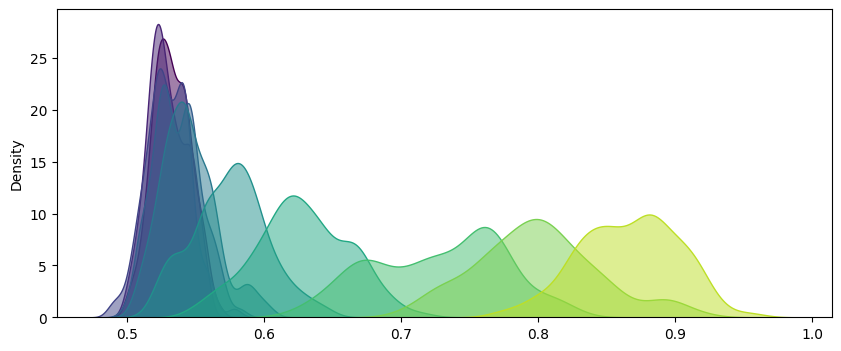

In [31]:
# for each bootstrap, read the p-value and make a graph, then calculate the graph edit distance to the original graph and store it
import seaborn as sns
idx = 0
window = windows[idx]
start, end = window

fig,ax = plt.subplots(figsize=(10, 4))

for deviation_idx,deviation in enumerate(np.logspace(-2, np.log10(0.5), num=10)):  # from 0.01 to 1.0
    differences = np.array([])
    for n in range(100):
        # read the p-values
        bootstrap_p_values = pd.read_pickle(f'{results}/{causality_name}/table_p_values_{start}-{end}_{deviation_idx}_{n}.pkl')
        bootstrap_p_values[np.eye(bootstrap_p_values.shape[0], dtype=bool)] = np.nan
        bootstrap_p_values = np.nan_to_num(bootstrap_p_values, nan=1.0)
        # ONLY NON AQUATIC SPECIES

        cut_value = 0.01
        bootstrap_p_values = (bootstrap_p_values <= cut_value).astype(int)    
        graph = nx.from_numpy_array(bootstrap_p_values, create_using=nx.DiGraph)
        
        # distance from graphs[0] to graph
        edg1 = set(graph.edges)
        edg2 = set(graphs[idx].edges)
        difference = 1. - len(edg1 & edg2) / len(edg1 | edg2)
        differences = np.append(differences, difference)

    # ax.hist(differences, bins=100, range=(0,1), alpha=0.5, color = plt.cm.viridis(deviation_idx / 10), label=f'{deviation:.2f}', edgecolor='black', linewidth=0.5);
    # kde plot
    sns.kdeplot(differences, ax=ax, bw_adjust=0.8, fill=True, color = plt.cm.viridis(deviation_idx / 10), label=f'{deviation:.2f}', alpha=0.5)
    

In [ ]:
# for each bootstrap, read the p-value and make a graph, then calculate the graph edit distance to the original graph and store it
idx = 0
window = windows[idx]
start, end = window

# fig,ax = plt.subplots(figsize=(10, 4))

deviations = np.append([np.logspace(-2, np.log10(0.5), num=10)], [0.77222655, 1.192667])  # from 0.01 to 1.0

for deviation_idx,deviation in enumerate(deviations):  # from 0.01 to 1.0
    differences = np.array([])
    for n in range(100):
        # read the p-values
        bootstrap_p_values = pd.read_pickle(f'{results}/{causality_name}/table_p_values_{start}-{end}_{deviation_idx}_{n}.pkl')
        bootstrap_p_values[np.eye(bootstrap_p_values.shape[0], dtype=bool)] = np.nan
        bootstrap_p_values = np.nan_to_num(bootstrap_p_values, nan=1.0)
        # ONLY NON AQUATIC SPECIES

        cut_value = 0.01
        bootstrap_p_values = (bootstrap_p_values <= cut_value).astype(int)    
        graph = nx.from_numpy_array(bootstrap_p_values, create_using=nx.DiGraph)
        
        # distance from graphs[0] to graph
        edg1 = set(graph.edges)
        edg2 = set(graphs[idx].edges)
        difference = 1. - len(edg1 & edg2) / len(edg1 | edg2)
        differences = np.append(differences, difference)

    # make violin plot with the differences distributions
    parts = ax.violinplot(1-differences, positions=[np.log10(deviation)], showmeans=False, showmedians=False, widths=0.03, bw_method=0.4, showextrema=False)
    for pc in parts['bodies']:
        pc.set_facecolor('green')
        pc.set_edgecolor("black")     # outline color
        pc.set_alpha(0.5)             # transparency

nice_ticks = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.5])
ax.set_xticks(np.log10(nice_ticks))
ax.set_xticklabels([str(t) for t in nice_ticks])

FileNotFoundError: [Errno 2] No such file or directory: 'results_basa/sensitivity_CGC/abundances_3/table_p_values_0-50_10_0.pkl'

In [ ]:
np.logspace(np.log10(1.192667), num=12)



array([0.01      , 0.01544452, 0.02385333, 0.03684032, 0.05689812,
       0.08787642, 0.13572093, 0.20961449, 0.32373957, 0.50000029,
       0.77222655, 1.192667  ])

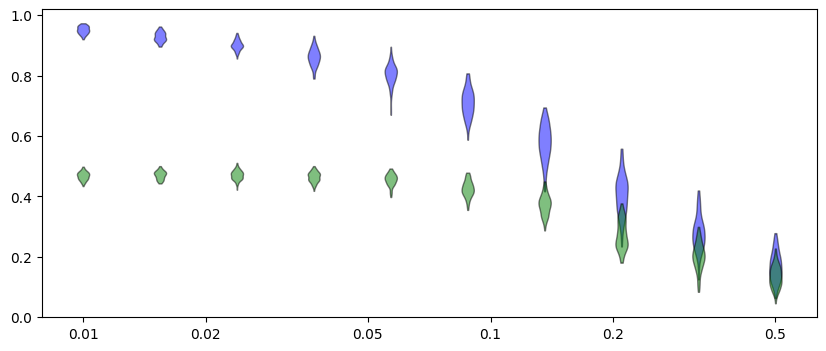

In [22]:
fig